# Setup 

<div style="background-color: #ffebee; border: 2px solid #d32f2f; padding: 10px; border-radius: 5px; color: #b71c1c;">
        <b>Caution:</b> The setup code below only needs to be run once per assignment. If you've already executed it, you can safely ignore this section and proceed to the <a href="#assignment-content" style="color: #d32f2f; text-decoration: underline;">Assignment Content</a>.
    </div>

This will run through setup of all necessary dependencies to complete the assignment.

## Install required tools

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    # fixing error like "No module named 'imp'"
    !sed -i -e 's/from imp import reload/from importlib import reload/' /usr/local/lib/python3.12/dist-packages/IPython/extensions/autoreload.py
else:
  import os
  # add local dependencies to PATH (for uv installation)
  os.environ['PATH'] = '/usr/local/bin:$HOME/.local/bin:' + os.environ['PATH']
  # add conda dependencies to PATH (for conda installation)
  os.environ['PATH'] = '/opt/anaconda3:~/anaconda3:~:~/miniconda3:/opt/miniconda3:' + os.environ['PATH']

## Install datasets

The code snippets below will mount your Google Drive folder (if in a Colab environment) and proceed to install the relevant datasets needed to complete the assignment.

In [2]:
if IN_COLAB:
    # TODO: For colab, Enter the foldername in your Google Drive
    # to the root of the assignment folder, where this notebook exists
    # e.g. 'XCS231N/XCS231N-A?/src/submission' # you need to update "A?" with the homework number
    FOLDERNAME = 'path to your submission folder, see the above description'
    WORK_DIR = '/content/drive/MyDrive/{}'.format(FOLDERNAME)
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive')

    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append(WORK_DIR)
else:
    # on local or azure, FOLDERNAME is set automatically
    FOLDERNAME=os.getcwd()
    WORK_DIR = FOLDERNAME

print(f"FOLDERNAME: ", FOLDERNAME)
print(f"WORK_DIR: ", WORK_DIR)

FOLDERNAME:  d:\course\XCS231N-Course\XCS231N-A2\src\submission
WORK_DIR:  d:\course\XCS231N-Course\XCS231N-A2\src\submission


In [3]:
print("Getting dataset: START")
%cd $WORK_DIR/xcs231n/datasets
!bash get_datasets.sh
%cd $WORK_DIR
print("Getting dataset: DONE")

Getting dataset: START
d:\course\XCS231N-Course\XCS231N-A2\src\submission\xcs231n\datasets
wget not found, using curl to download datasets...
d:\course\XCS231N-Course\XCS231N-A2\src\submission
Getting dataset: DONE


# Package Manager Setup

Below you have the option to run through the installation of `uv` package manager. Optionally, you can still work with `conda`.

## `uv` (preferred)

In [ ]:
if not IN_COLAB:
  %cd $WORK_DIR/../..
  !source install.sh -r
  !source .venv/bin/activate

## `conda` (legacy)

In [ ]:
# uncomment to use conda
# if IN_COLAB:
#     !pip install -q condacolab
#     import condacolab
#     condacolab.install()
#     %cd $WORK_DIR/src
#     !conda env create -f environment.yml
#     !exec bash
# else:
#     %cd $WORK_DIR/src
#     !conda env create -f environment.yml

---

<a id="assignment-content"></a>

# Assignment Content

# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise, you will implement a dropout layer and modify your fully connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [4]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from xcs231n.classifiers.fc_net import *
from xcs231n.data_utils import get_CIFAR10_data
from xcs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from xcs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [5]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Dropout: Forward Pass
In the file `xcs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [6]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout: Backward Pass
In the file `xcs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [7]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less.
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:

### START ANSWER HERE ###
If you do not divide the values in the dropout layer by p during the training phase of inverted dropout, the expected output of the network during training will be incorrect.
1. The core idea of dropout is to randomly drop (set to zero) some fraction of neuron outputs during training to prevent overfitting.
2. If we don't divide by p, activations are Lowered: The average activation values across the entire network during training will be reduced by a factor of \(p\) and training impaired.
### END ANSWER HERE ###

# Fully Connected Networks with Dropout
In the file `xcs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the network receives a value that is not 1 for the `dropout_keep_ratio` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [8]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout_keep_ratio in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout_keep_ratio)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        weight_scale=5e-2,
        dtype=np.float64,
        dropout_keep_ratio=dropout_keep_ratio,
        seed=123
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    # Relative errors should be around e-6 or less.
    # Note that it's fine if for dropout_keep_ratio=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Processing forward pass for label: W1
Processing forward pass for label: W2
Processing final layer
Processing forward pass for label: W3
Completed forward pass.
Computed softmax loss
Completed backward pass for layer 3
Calcualted grads for 3
Completed backward pass for layer 2
Completed backward pass for layer 1
Completed backward pass. All gradients computed.
Initial loss:  2.3004790897684924
Processing forward pass for label: W1
Processing forward pass for label: W2
Processing final layer
Processing forward pass for label: W3
Completed forward pass.
Computed softmax loss
Completed backward pass for layer 3
Calcualted grads for 3
Completed backward pass for layer 2
Completed backward pass for layer 1
Completed backward pass. All gradients computed.
Processing forward pass for label: W1
Processing forward pass for label: W2
Processing final layer
Processing forward pass for label: W3
Completed forward pass.
Computed softmax loss
Completed backward pass f

# Regularization Experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [9]:
# Train two identical nets, one with dropout and one without.
np.random.seed(231)
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet(
        [500],
        dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule='adam',
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

1
Processing forward pass for label: W1
Processing final layer
Processing forward pass for label: W2
Completed forward pass.
Computed softmax loss
Completed backward pass for layer 2
Calcualted grads for 2
Completed backward pass for layer 1
Completed backward pass. All gradients computed.
(Iteration 1 / 125) loss: 7.856642
Processing forward pass for label: W1
Processing final layer
Processing forward pass for label: W2
Completed forward pass.
Processing forward pass for label: W1
Processing final layer
Processing forward pass for label: W2
Completed forward pass.
Processing forward pass for label: W1
Processing final layer
Processing forward pass for label: W2
Completed forward pass.
Processing forward pass for label: W1
Processing final layer
Processing forward pass for label: W2
Completed forward pass.
Processing forward pass for label: W1
Processing final layer
Processing forward pass for label: W2
Completed forward pass.
Processing forward pass for label: W1
Processing final laye

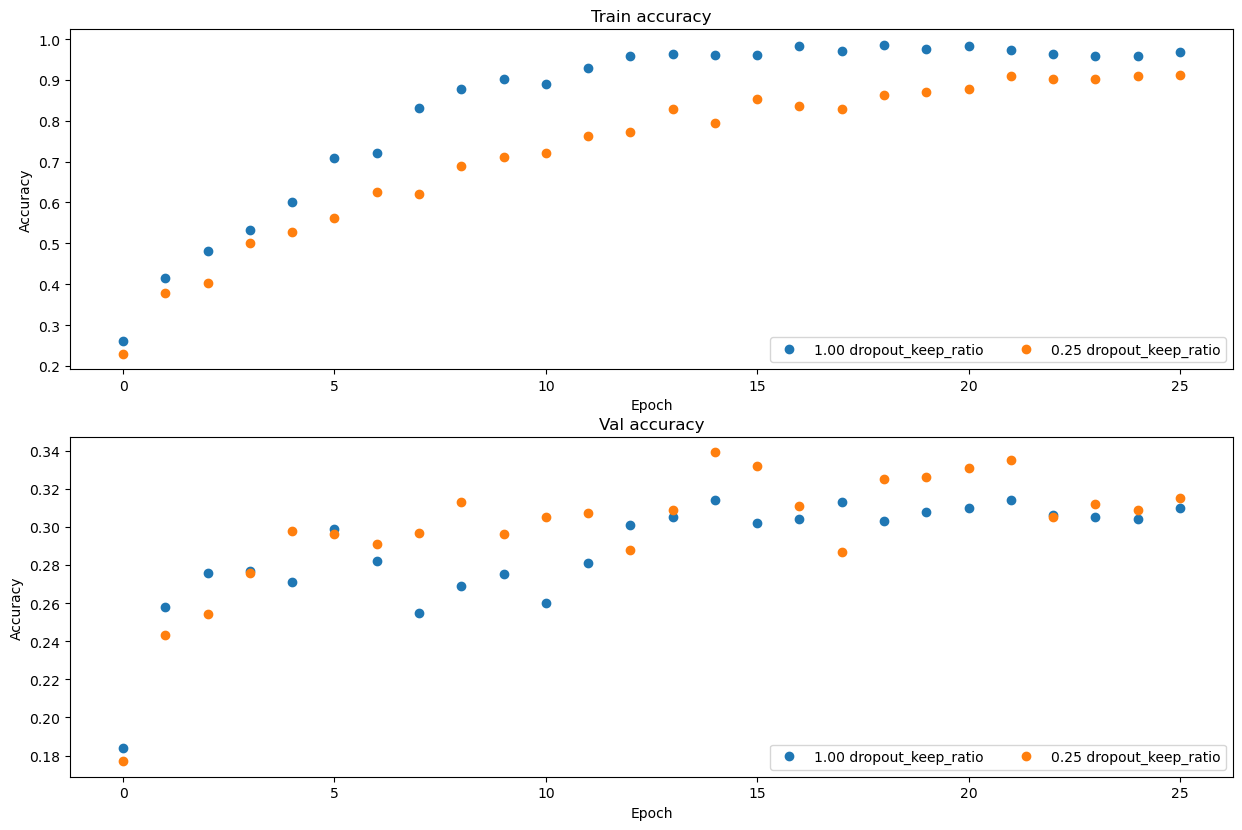

In [10]:
# Plot train and validation accuracies of the two models.
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:

### START ANSWER HERE ###
1. Validation accuracy with using dropout keep ratio of 0.25 is higher than when we use no dropout.
### END ANSWER HERE ###

# Submission

**You will need to submit the answers from this notebook on Gradescope.**